In [ ]:
# Prepare Environment

import os
import sys
from pathlib import Path

import yaml
import torch
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv("/home/colin/projects/CISC_473_project/.env")

REPO_DIR = Path(os.getenv("REPO_DIR"))
DATA_ROOT = Path(os.getenv("DATA_ROOT"))
SAVE_DIR = Path(os.getenv("SAVE_DIR"))

sys.path.append(str(REPO_DIR))

from src.eval_utils import evaluate_all_models, print_summary_table

with open(REPO_DIR / "configs" / "default.yaml", "r") as f:
    cfg = yaml.safe_load(f)

device = torch.device("cpu")


In [2]:
# Eval: run evaluation for all 4 variants on CPU

results = evaluate_all_models(cfg, DATA_ROOT, SAVE_DIR, device=device)

print_summary_table(results)



===== PRUNE =====
CKPT: /home/colin/projects/CISC_473_project/checkpoints/run1/prune_best.pth
[Eval] Re-applying channel pruning in eval: ch_sparsity=0.1, steps=1


/home/colin/projects/CISC_473_project/torch-env/lib/python3.10/site-packages/torch_pruning/pruner/algorithms/base_pruner.py:91: UserWarning: ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.
  warnings.warn(


[ChannelPruning] Starting channel pruning with ch_sparsity=0.1, iterative_steps=1
[ChannelPruning] Pruning complete. Model now has fewer channels.

===== QAT =====
CKPT: /home/colin/projects/CISC_473_project/checkpoints/run1/qat_int8_final.pth


/home/colin/projects/CISC_473_project/src/eval_utils.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")
/home/colin/proje


===== QAT_PRUNE =====
CKPT: /home/colin/projects/CISC_473_project/checkpoints/run1/qat_prune_int8_final.pth
[Eval] Re-applying channel pruning in eval: ch_sparsity=0.1, steps=1
[ChannelPruning] Starting channel pruning with ch_sparsity=0.1, iterative_steps=1


/home/colin/projects/CISC_473_project/src/eval_utils.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")
/home/colin/proje

[ChannelPruning] Pruning complete. Model now has fewer channels.


/home/colin/projects/CISC_473_project/torch-env/lib/python3.10/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  prepared = prepare(
/home/colin/projects/CISC_473_project/torch-env/lib/python3.10/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/colin/projects/CISC_473_project/torch-env/lib/python3.10/site-packages/torch/ao/quantization/utils.py:407: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(



===== SUMMARY TABLE =====
Model        Params(M)  Size(MB)  Sparsity  Lat(ms)  Speedup  PSNR(dB)  ΔPSNR  SSIM   ΔSSIM
-------------------------------------------------------------------------------------------
base           28.95   110.51     0.00    76.33     1.00    19.63    0.00  0.7069  +0.0000
prune          23.39    89.29     0.50    72.06     1.06    19.16   -0.47  0.6685  -0.0385
qat            28.95    27.77     0.00    54.15     1.41    18.94   -0.69  0.6595  -0.0475
qat_prune      23.39    22.45     0.50    47.35     1.61    18.62   -1.01  0.6850  -0.0219


In [ ]:
import pandas as pd

# results is the dict from evaluate_all_models
df = pd.DataFrame(results).T  # rows: models, cols: metrics

# enforce row order
df = df.loc[["base", "prune", "qat", "qat_prune"]]

# add speedup column
base_lat = df.loc["base", "Latency_ms_mean"]
df["Speedup_vs_base"] = base_lat / df["Latency_ms_mean"]

df.style.format("{:.2f}")


,Loss,PSNR,SSIM,Params,Sparsity,Size_MB,Latency_ms_mean,Latency_ms_std,Speedup_vs_base
base,0.01,19.63,0.71,28947843.00,0.00,110.51,76.33,3.89,1.00
prune,0.01,19.16,0.67,23386176.00,0.50,89.29,72.06,14.03,1.06
qat,0.01,18.94,0.66,28947843.00,0.00,27.77,54.15,0.37,1.41
qat_prune,0.01,18.62,0.69,23386176.00,0.50,22.45,47.35,1.57,1.61


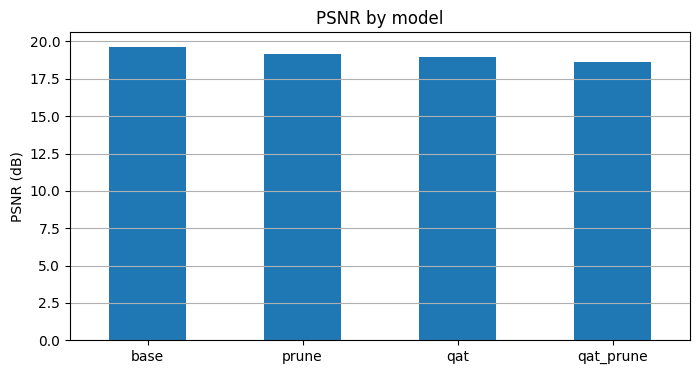

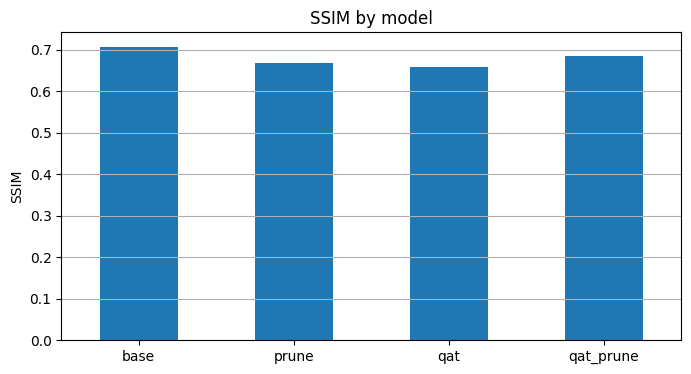

In [4]:
plt.figure(figsize=(8,4))
df["PSNR"].plot(kind="bar")
plt.ylabel("PSNR (dB)")
plt.title("PSNR by model")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(8,4))
df["SSIM"].plot(kind="bar")
plt.ylabel("SSIM")
plt.title("SSIM by model")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


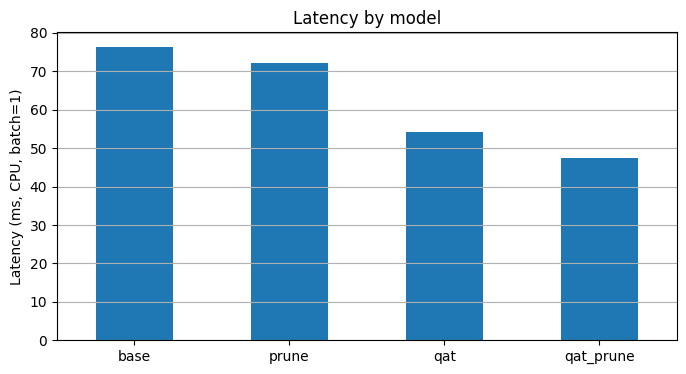

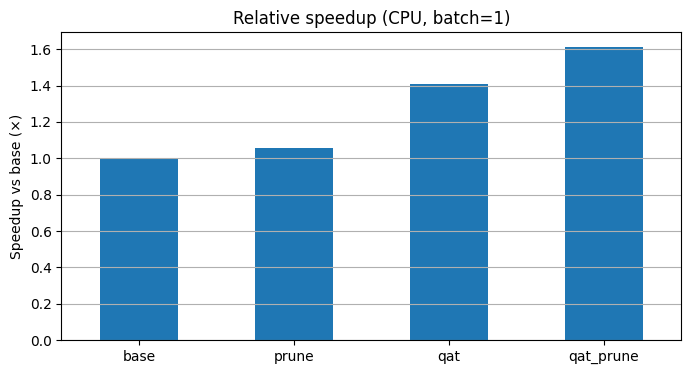

In [5]:
plt.figure(figsize=(8,4))
df["Latency_ms_mean"].plot(kind="bar")
plt.ylabel("Latency (ms, CPU, batch=1)")
plt.title("Latency by model")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(8,4))
df["Speedup_vs_base"].plot(kind="bar")
plt.ylabel("Speedup vs base (×)")
plt.title("Relative speedup (CPU, batch=1)")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


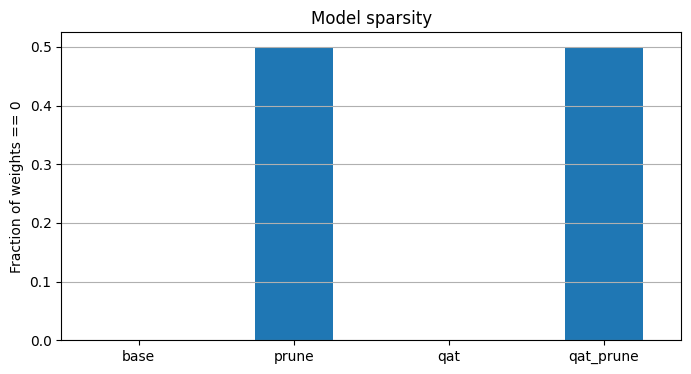

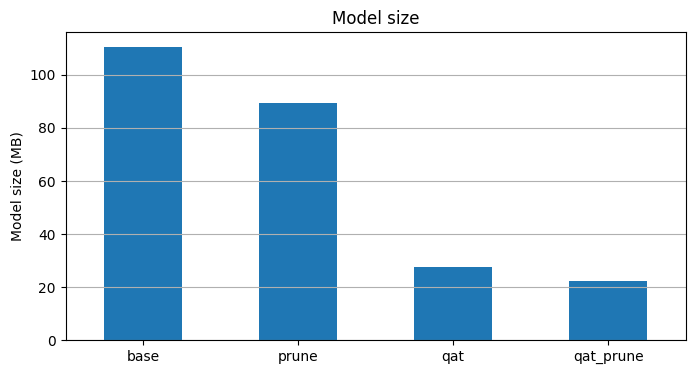

In [6]:
plt.figure(figsize=(8,4))
df["Sparsity"].plot(kind="bar")
plt.ylabel("Fraction of weights == 0")
plt.title("Model sparsity")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(8,4))
df["Size_MB"].plot(kind="bar")
plt.ylabel("Model size (MB)")
plt.title("Model size")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


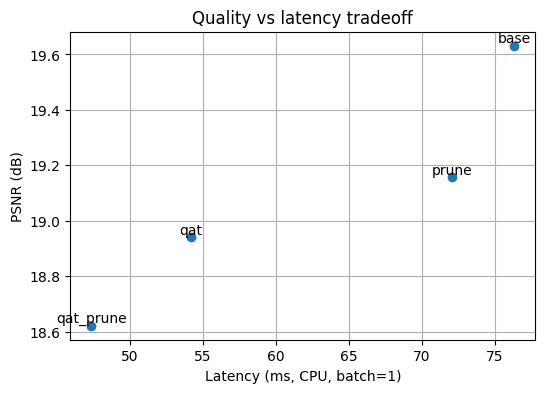

In [7]:
import matplotlib.pyplot as plt

order = ["base", "prune", "qat", "qat_prune"]
df_plot = df.loc[order]

plt.figure(figsize=(6, 4))
plt.scatter(df_plot["Latency_ms_mean"], df_plot["PSNR"])

for name in order:
    x = df_plot.loc[name, "Latency_ms_mean"]
    y = df_plot.loc[name, "PSNR"]
    plt.text(x, y, name, ha="center", va="bottom")

plt.xlabel("Latency (ms, CPU, batch=1)")
plt.ylabel("PSNR (dB)")
plt.title("Quality vs latency tradeoff")
plt.grid(True)
plt.show()


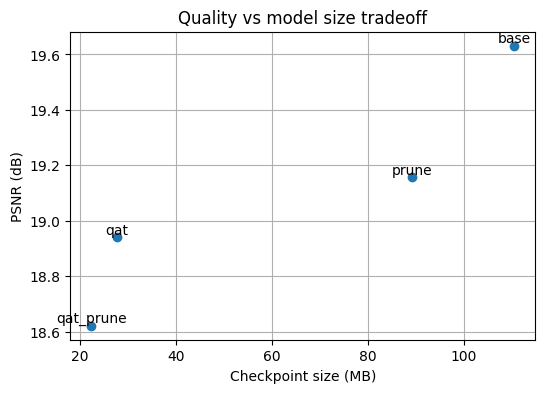

In [8]:
plt.figure(figsize=(6, 4))
plt.scatter(df_plot["Size_MB"], df_plot["PSNR"])

for name in order:
    x = df_plot.loc[name, "Size_MB"]
    y = df_plot.loc[name, "PSNR"]
    plt.text(x, y, name, ha="center", va="bottom")

plt.xlabel("Checkpoint size (MB)")
plt.ylabel("PSNR (dB)")
plt.title("Quality vs model size tradeoff")
plt.grid(True)
plt.show()
